In [1]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
import torch.nn.functional as F
#Image
from PIL import Image
from skimage import io, transform
from IPython.display import display
import matplotlib.pyplot as plt
from torchvision import transforms
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pyplot as plt
import string
# Allows us to use arrays to manipulate and store data
import numpy as np
import random
import seaborn
from torchvision import models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import math
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add, Input, Dropout, Dense, concatenate, Embedding,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
resnext101=models.resnet.resnext101_32x8d(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:03<00:00, 106MB/s]  


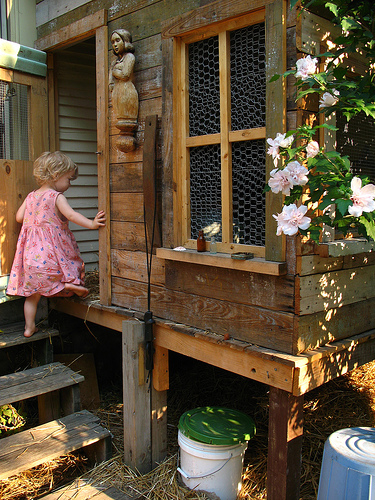

In [3]:
#Sample Image from the Flickr8k Dataset
img=Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')
img

In [4]:
#Defining transform to get our image to its requirements provided by the ResNext101 Model
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])

In [5]:
img_t=transform(img)
img_t.shape

torch.Size([3, 224, 224])

In [6]:
#Checking out ResNext101 for the image
batch_t=torch.unsqueeze(img_t,0)

resnext101.eval()

out = resnext101(batch_t)

#Classes.txt not used in the model, just used to check out ResNext101 predictions
with open('/kaggle/input/imagenet-classestxt/imagenet-classes.txt') as f:
    classes=[line.strip() for line in f.readlines()]

#Percentage Classification for the 1000 classes of image net
_,indices = torch.sort(out, descending=True)
percentage= torch.nn.functional.softmax(out,dim=1)[0]*100
[(classes[idx],percentage[idx].item()) for idx in indices[0][:10]]

[('apiary, bee house', 52.16262435913086),
 ('yurt', 41.7625846862793),
 ('honeycomb', 1.327736258506775),
 ('mobile home, manufactured home', 0.5176102519035339),
 ('greenhouse, nursery, glasshouse', 0.46617215871810913),
 ('thatch, thatched roof', 0.39590632915496826),
 ('overskirt', 0.2568483054637909),
 ('patio, terrace', 0.21178367733955383),
 ('rain barrel', 0.18614442646503448),
 ('bee', 0.17982156574726105)]

In [7]:
#Converting our txt captions file to a csv file
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [8]:
def preprocess_caption(caption):
    punct_table = str.maketrans("", "", string.punctuation)
    # Extract separate tokens
    caption = caption.split()
    # Make tokens lowercase
    caption = [word.lower() for word in caption]
    # Remove punctuation
    caption = [word.translate(punct_table) for word in caption]
    # Remove single letters
    caption = [word for word in caption if len(word) > 1]
    # Remove numbers
    caption = [word for word in caption if word.isalpha()]
    return " ".join(caption)


In [9]:
# Perfromed the preprocessing on the entire dataset
minl=1000
maxl=-1
for i,caption in enumerate(data['caption']):
    caption=preprocess_caption(caption)
    minl=min(minl,len(caption.split()))
    maxl=max(maxl,len(caption.split()))
    data['caption'][i]=caption
print(maxl,minl)
data

32 0


,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin
...,...,...
40450,997722733_0cb5439472.jpg,man in pink shirt climbs rock face
40451,997722733_0cb5439472.jpg,man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,person in red shirt climbing up rock face cove...
40453,997722733_0cb5439472.jpg,rock climber in red shirt


In [10]:
#defining a dictionary containing all the captions for the key(image)
image_captions=dict()
list_of_captions=[]
count=0
for image in data['image'].unique():
    key=image.split(".")[0]
    
    image_captions[key]=[]
    for caption in (data.loc[data['image']==image]['caption']):
        
        #we only will append the captions whose length is more than 1, have a one word caption does not make sense
        if(len(caption.split()) >=2):
            
            #tokens for SOS and EOS
            caption='startseq ' + caption + ' endseq'
            list_of_captions.append(caption)
            image_captions[key].append(caption)
    if(len(image_captions[key]) !=5):
        count=count+1


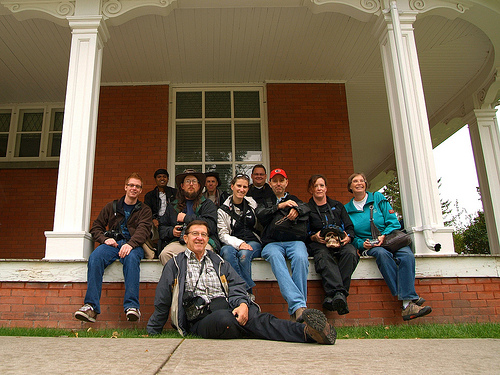

startseq group of people are gathered on white pillared porch for photo endseq
startseq group of people are sitting in front of red brick and white trim building endseq
startseq group of people are sitting on the porch of brick building endseq
startseq group of people gather in front of red house endseq
startseq group of ten people posing outside of classicstyle building endseq


In [11]:
random_key = random.choice(list(image_captions.keys()))
imgrandom = Image.open(f'/kaggle/input/flickr8k/Images/{random_key}.jpg')
imgrandomt= transform(imgrandom)
display(imgrandom)
for caption in image_captions[random_key]:
    print(caption)

In [12]:
#Function used for feature extraction
def get_activation(name):
    def hook(resnext101, input, output):
            activation[name] = output.detach()
    return hook

In [ ]:

feature_vectors=dict()
idx=1
for image in image_captions.keys():
    imgf = Image.open(f'/kaggle/input/flickr8k/Images/{image}.jpg')
    imgft=transform(imgf)
    batch_ft=torch.unsqueeze(imgft,0)
    activation={}
    resnext101.avgpool.register_forward_hook(get_activation('feats'))
    out=resnext101(batch_ft)
    feature_vectors[image]=activation['feats']
    idx+=1
    print(idx)
    


In [ ]:
for key,value in feature_vectors.items():
    feature_vectors[key]=value.view(1,2048)

In [ ]:
# import json

# # Save the dictionary to a file
# with open("feature_vectors.json", "w") as file:
#     json.dump(feature_vectors, file)

# file_path = 'feature_dict.pt'

# # Save the dictionary
# torch.save(feature_vectors, file_path)

In [13]:
file_path = '/kaggle/input/resnext-featuredict/feature_dict.pt'
feature_vectors = torch.load(file_path)
resnext_vectors={}
for key in feature_vectors.keys():
    resnext_vectors[key]=feature_vectors[key].squeeze().numpy()
resnext_vectors[random_key].shape

(2048,)

In [14]:
#Splitting of dataset into Training,Validation,Testing (4:1:1)
keys = list(image_captions.keys())
values =list(image_captions.values())

# Split the keys and values into train, validation, and test sets
train_keys, remaining_keys, train_values, remaining_values = train_test_split(keys, values, test_size=0.2, random_state=42)
val_keys, test_keys, val_values, test_values = train_test_split(remaining_keys, remaining_values, test_size=0.5, random_state=42)

# Create train, validation, and test dictionaries
train_dict = {k: v for k, v in zip(train_keys, train_values)}
val_dict = {k: v for k, v in zip(val_keys, val_values)}
test_dict = {k: v for k, v in zip(test_keys, test_values)}

In [15]:
print("Length of training Dictionary:", len(train_dict))
print("Length of validation Dictionary:", len(val_dict))
print("Length of testing Dictionary:", len(test_dict))

Length of training Dictionary: 6472
Length of validation Dictionary: 809
Length of testing Dictionary: 810


In [16]:
trainlist_captions = []
vallist_captions=[]
# List of all captions
for captions in train_dict.values():
    for caption in captions:
        trainlist_captions.append(caption)
for captions in val_dict.values():
    for caption in captions:
        vallist_captions.append(caption)


In [17]:
#Vocabulary list of our dataset
def vocab(text):
    vocab_list=set()
    for caption in text:
        words=caption.split()
        for word in words:
            vocab_list.add(word)
    return vocab_list

vocab_list=vocab(list_of_captions)

In [18]:
#tokenize all of the captions
inttoword=dict()
wordtoint=dict()
idx=3
inttoword[1]='startseq'
wordtoint['startseq']=1
inttoword[2]='endseq'
wordtoint['endseq']=2
inttoword[0]=''
wordtoint['']=0

for word in vocab_list:
    if word=='startseq' or word=='endseq':
        continue
    inttoword[idx]=word
    wordtoint[word]=idx
    idx+=1

In [19]:
def numericalize(dict):
    numerical_captions={}
    for image, captions in dict.items():
        numerical_captions[image] = []
        for caption in captions:
            # Split the caption into words
            words = caption.split()
            # Numericalize the words using the word_to_int dictionary
            for x in words:
                if x not in wordtoint:
                    print("A problem")
                    
            numerical_caption = [wordtoint[word] for word in words]
            # Append the numericalized caption to the list
            numerical_captions[image].append(numerical_caption)
    return numerical_captions

In [20]:
train_n_dict=numericalize(train_dict)
val_n_dict = numericalize(val_dict)


In [21]:
# tokenizer = Tokenizer()
# # Assigns unqiue integer to every word
# tokenizer.fit_on_texts(list_of_captions)
# #vocabulary size
# vocab_size = len(tokenizer.word_index) + 1 
# #maximum length of a caption
# max_len = max(len(d.split()) for d in list_of_captions) 

# print("Vocab Size:",vocab_size)
# print("Maximum length of preprocessed captions:", max_len)

In [22]:
vocab_size=8766
max_len=34
print(len(train_n_dict),len(val_n_dict),len(test_dict))

6472 809 810


In [23]:
def data_loader(features,dict,batch_size,max_len):
    inpcnn=[]
    inprnn=[]
    output=[]
    cnt=0
    while True:
        for key, captions in dict.items():
            cnt+=1
            pic = resnext_vectors[key]
            for cap in captions:
                seq = cap
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    inpcnn.append(pic)
                    inprnn.append(in_seq)
                    output.append(out_seq)
                    # store
            if cnt==batch_size:
                yield [np.array(inpcnn), np.array(inprnn)], np.array(output)
                inpcnn=[]
                inprnn=[]
                output=[]
                cnt=0

In [24]:
# feature extractor model
inpcnn = Input(shape=(2048,))
dropout1 = Dropout(0.5)(inpcnn)
linear1 = Dense(256, activation='relu')(dropout1)

# sequence model (the two parallel paths)
inprnn = Input(shape=(max_len,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(inprnn)
dropout2 = Dropout(0.5)(embedding)
lstm = LSTM(256)(dropout2)

# decoder model
adder = add([linear1, lstm])
linear2 = Dense(256, activation='relu')(adder)
outputs = Dense(vocab_size, activation='softmax')(linear2)

# THE MODEL
image_captioner = Model(inputs=[inpcnn, inprnn], outputs=outputs)
image_captioner.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(image_captioner.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      2244096     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [25]:
def train_model(model,batch_size,epochs):
    batch_size = batch_size
    epochs = epochs
    steps = math.ceil(len(train_dict) / batch_size)
    for i in range(epochs):
        print(f'Epoch {i+1}')
        train_loader = data_loader(resnext_vectors, train_n_dict, batch_size, max_len)
        val_loader = data_loader(resnext_vectors, val_n_dict, batch_size, max_len)
        model.fit(train_loader, epochs=1, steps_per_epoch=steps, verbose=1)

In [26]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 85s 374ms/step - loss: 5.3896
Epoch 2
203/203 [==============================] - 58s 286ms/step - loss: 4.1446
Epoch 3
203/203 [==============================] - 59s 292ms/step - loss: 3.7199
Epoch 4
203/203 [==============================] - 58s 287ms/step - loss: 3.4729
Epoch 5
203/203 [==============================] - 57s 282ms/step - loss: 3.2917


In [27]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 58s 283ms/step - loss: 3.1501
Epoch 2
203/203 [==============================] - 57s 281ms/step - loss: 3.0373
Epoch 3
203/203 [==============================] - 58s 284ms/step - loss: 2.9406
Epoch 4
203/203 [==============================] - 57s 282ms/step - loss: 2.8530
Epoch 5
203/203 [==============================] - 58s 286ms/step - loss: 2.7797


In [28]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 58s 286ms/step - loss: 2.7158
Epoch 2
203/203 [==============================] - 57s 281ms/step - loss: 2.6583
Epoch 3
203/203 [==============================] - 58s 285ms/step - loss: 2.6137
Epoch 4
203/203 [==============================] - 57s 283ms/step - loss: 2.5680
Epoch 5
203/203 [==============================] - 58s 286ms/step - loss: 2.5242


In [29]:
train_model(image_captioner,32,5)

Epoch 1
203/203 [==============================] - 58s 285ms/step - loss: 2.4854
Epoch 2
203/203 [==============================] - 59s 289ms/step - loss: 2.4393
Epoch 3
203/203 [==============================] - 58s 284ms/step - loss: 2.4015
Epoch 4
203/203 [==============================] - 58s 283ms/step - loss: 2.3669
Epoch 5
203/203 [==============================] - 58s 286ms/step - loss: 2.3417


In [36]:
image_captioner.save('ic2.h5')

In [25]:
# image_captioner = load_model('/kaggle/input/weights/ic2.h5')

**Generating Captions: Beam Search**

In [30]:
#expects image in the Image.open form
def captioner(model, feature, max_len):
    start_token=[1]
    end_token=[2]
    beam_index=3
    
    start_word = [[start_token, 0.0]]
    
    while len(start_word[0][0]) < max_len+1:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len)
            
            preds = model.predict([feature, np.array(par_caps)],verbose=0)
            
            # Getting the top beam_index predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [inttoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [31]:
def featureextraction(image):
    def get_activation(name):
        def hook(resnext101, input, output):
            activation[name] = output.detach()
        return hook
    batch_image=torch.unsqueeze(image,0)
    activation={}
    resnext101.avgpool.register_forward_hook(get_activation('feat'))
    out=resnext101(batch_image)
    featureex=activation['feat']
    featureex=featureex.squeeze().numpy()
    featureex = np.expand_dims(featureex, axis=0)
    return featureex

Predicted: girl in red shirt walks down the street


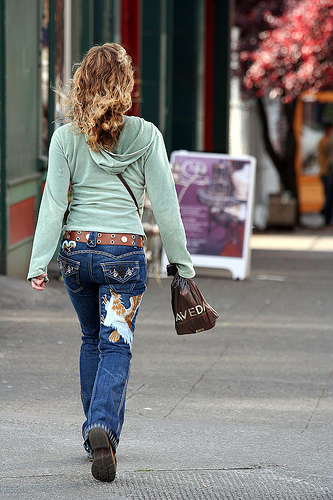

startseq blonde woman wearing green shirt and blue jeans walks away endseq
startseq girl in blue hoodie is carrying brown bag endseq
startseq woman in patterned blue jeans and green sweater walks away whilst carrying brown plastic bag endseq
startseq woman walking wearing green shirt and jeans endseq
startseq it looks like the girl went shopping and got something from the aveda store endseq


In [32]:
random_key = random.choice(list(train_dict.keys()))
imgrandom = Image.open(f'/kaggle/input/flickr8k/Images/{random_key}.jpg')
imgrandomt= transform(imgrandom)

featureex = featureextraction(imgrandomt)

print("Predicted:",captioner(image_captioner,featureex,max_len))
display(imgrandom)
for caption in image_captions[random_key]:
    print(caption)

**BLEU Evaluation Analysis**

In [36]:
#Let us try BLEU on some random images firstly
def bleueval(model):
    transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229, 0.224, 0.225])])
    random_key = random.choice(list(test_dict.keys()))
    imgrandom = Image.open(f'/kaggle/input/flickr8k/Images/{random_key}.jpg')
    imgrandomt= transform(imgrandom)
    featureex = featureextraction(imgrandomt)
    predicted_caption=captioner(model,featureex,max_len)
    display(imgrandom)
    print("Predicted:",predicted_caption)
    predicted=[]
    reference=[]
    for caption in image_captions[random_key]:
        reference_caption=' '.join(caption.split()[1:-1])
        print("Reference:",reference_caption)
        predicted.append(predicted_caption.split())
        reference.append(reference_caption.split())
    
    smooth_fn = SmoothingFunction().method3
    bleu_1=(sentence_bleu( reference,predicted_caption.split(), smoothing_function=smooth_fn, weights=(1, 0, 0, 0)))
    bleu_2=(sentence_bleu(reference, predicted_caption.split(), smoothing_function=smooth_fn, weights=(0.5, 0.5, 0, 0)))
    bleu_3=(sentence_bleu(reference, predicted_caption.split(), smoothing_function=smooth_fn, weights=(0.33, 0.33, 0.33, 0)))
    bleu_4=(sentence_bleu(reference, predicted_caption.split(), smoothing_function=smooth_fn, weights=(0.25, 0.25, 0.25, 0.25)))
   
    print("BLEU-1:", (bleu_1))
    print("BLEU-2:", (bleu_2))
    print("BLEU-3:", (bleu_3))
    print("BLEU-4:", (bleu_4))

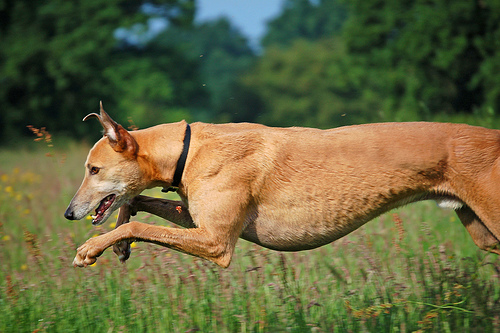

Predicted: brown dog is running through the grass
Reference: brown dog is jumping through field
Reference: brown dog jumps over the grass
Reference: tan dog jumps and runs in field
Reference: the large brown dog is jumping through the tall grass
Reference: the tan dog in black collar runs across field
BLEU-1: 0.8571428571428571
BLEU-2: 0.7559289460184544
BLEU-3: 0.48880691657030756
BLEU-4: 0.34572078464194106


In [38]:
bleueval(image_captioner)

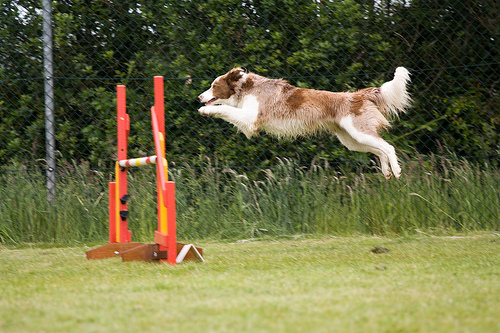

Predicted: brown and white dog is running through an obstacle course
Reference: brown and white dog jumping over red yellow and white pole
Reference: dog is jumping over gate
Reference: dog jumping over hurdle
Reference: dog jumps over hurdle
Reference: large brown dog jumps over red hurdle
BLEU-1: 0.45241870901797976
BLEU-2: 0.4265444494430359
BLEU-3: 0.3486026025842772
BLEU-4: 0.27007097700389543


In [49]:
bleueval(image_captioner)

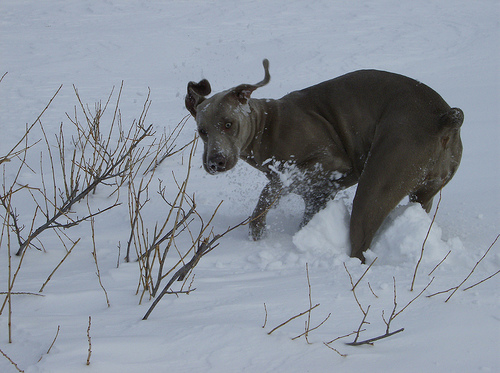

Predicted: black dog runs through the snow
Reference: brown dog is up to its knees in snow
Reference: brown dog plays in the snow
Reference: dog plays in the snow
Reference: grey dog with bobbed tail digs in snow
Reference: large gray dog is playing in the deep snow
BLEU-1: 0.5
BLEU-2: 0.316227766016838
BLEU-3: 0.23549424823785386
BLEU-4: 0.1796520559815421


In [46]:
bleueval(image_captioner)

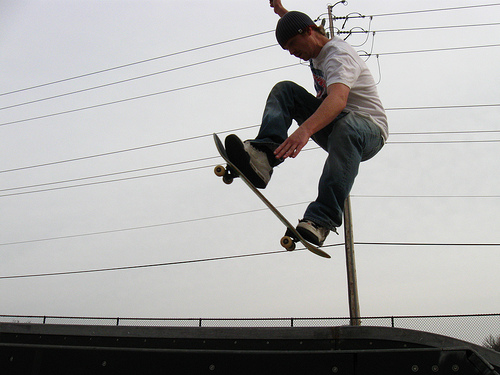

Predicted: skateboarder does trick on ramp
Reference: skateboarder does trick in midair
Reference: skateboarder in the air in front of wires
Reference: skateboarder jumps into the air
Reference: skateboarder in jeans and tshirt performing jump
Reference: the skateboarder is leaping in the air in front of the telegraph pole
BLEU-1: 0.6
BLEU-2: 0.5477225575051662
BLEU-3: 0.4677351412871982
BLEU-4: 0.3976353643835253


In [51]:
bleueval(image_captioner)

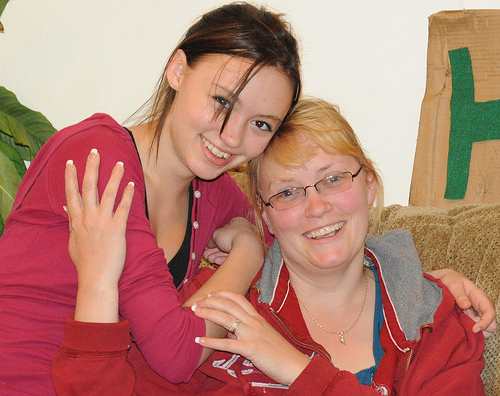

Predicted: group of people smile for picture
Reference: girl and woman pose for picture
Reference: woman and young woman pose with their arms around each other
Reference: young girl posing with another woman each smiling
Reference: two women smile cheerfully at the viewer
Reference: two women wearing red are smiling at the camera
BLEU-1: 0.5
BLEU-2: 0.316227766016838
BLEU-3: 0.23549424823785386
BLEU-4: 0.1796520559815421


In [58]:
bleueval(image_captioner)

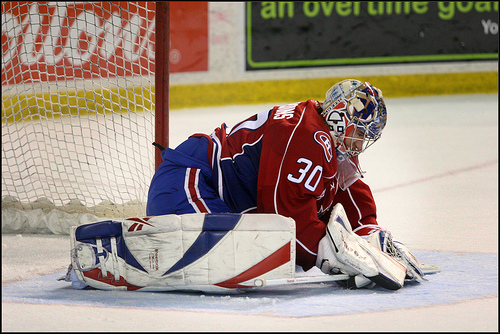

Predicted: two hockey players huddle on the ice
Reference: goalie is crouching in defensive position in front of the goal
Reference: hockey player in blue and red guarding the goal
Reference: an ice hockey goalkeeper in red and blue strip is on his knees in front of the goal
Reference: an ice hockey player is bending down on the ice
Reference: the hockey player knelt on the ice
BLEU-1: 0.5714285714285714
BLEU-2: 0.4364357804719847
BLEU-3: 0.34016320005192946
BLEU-4: 0.2626909894424158


In [60]:
bleueval(image_captioner)

In [62]:
def evaluate_model(model, dictionary, max_len):
    actual_captions, predicted_captions = [], []
    idx=1
    total=len(dictionary)
    for image, captions in dictionary.items():
        idx=idx+1
        featureex = resnext_vectors[image]
        featureex = np.expand_dims(featureex, axis=0)
        actual_captions.append([caption.split()[1:-1] for caption in captions])
        predicted_captions.append(captioner(model,featureex,max_len).split())
        if idx==50:
            break
     # BLEU score
    smooth_fn = SmoothingFunction().method3
    print("BLEU-1:", corpus_bleu(actual_captions, predicted_captions, smoothing_function=smooth_fn, weights=(1.0, 0, 0,0)))
    print("BLEU-2:", corpus_bleu(actual_captions, predicted_captions, smoothing_function=smooth_fn,weights=(0.5, 0.5,0,0)))
    print("BLEU-3:", corpus_bleu(actual_captions, predicted_captions, smoothing_function=smooth_fn,weights=(0.33,0.33,0.33,0)))
    print("BLEU-4:", corpus_bleu(actual_captions, predicted_captions, smoothing_function=smooth_fn,weights=(0.25, 0.25,0.25,0.25)))


In [63]:
evaluate_model(image_captioner,test_dict,max_len)

BLEU-1: 0.4830917874396135
BLEU-2: 0.2933087866712508
BLEU-3: 0.19764591985809987
BLEU-4: 0.12182218604991372
